In [15]:
import sys
import os
import collections
from collections import defaultdict
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import re
from tabula import read_pdf
import csv

import requests
from bs4 import BeautifulSoup

%pip install google-search-results
from serpapi import GoogleSearch

Note: you may need to restart the kernel to use updated packages.


In [16]:
def calculate_scores(user_data):

    data_bac = pd.read_csv("./BAC CSV/bac2019.csv")
    # Automatically map subjects to their respective fields
    subjects = {
        user_data.get('Subiect ea', ''): user_data.get('NOTA_FINALA_EA', 0),
        user_data.get('Subiect ec', ''): user_data.get('NOTA_FINALA_EC', 0),
        user_data.get('Subiect ed', ''): user_data.get('NOTA_FINALA_ED', 0)
    }

    # Extract other relevant fields
    digital_skills = user_data.get('PUNCTAJ DIGITALE', 0)
    communication_skills = user_data.get('ORAL_PMO', 0)
    overall_grade = user_data.get('Medie', 0)
    profile = user_data.get('Profil', '')
    specialization = user_data.get('Specializare', '')

    # Initialize subject-based variables
    math_grade = 0
    science_grade = 0
    language_grade = 0
    history_grade = 0
    art_grade = 0
    sports_grade = 0
    vocational_grade = 0
    logic_grade= 0
    info_grade = 0

    # Assign grades based on subject mapping
    for subject, grade in subjects.items():
        if any(math_subj in subject for math_subj in ['Matematică MATE-INFO', 'Matematică ST-NAT', 'Matematică TEHN']):
            math_grade = grade
        elif any(sci in subject for sci in ['Biologie vegetală și animală', 'Anatomie și fiziologie umană, genetică și ecologie umană', 'Chimie organică TEH Nivel I/II', 'Chimie anorganică TEH Nivel I/II', 'Chimie organică TEO Nivel I/II', 'Chimie anorganică TEO Nivel I/II', 'Fizică TEO', 'Fizică TEH']):
            science_grade = grade
        elif any(lang in subject for lang in ['Limba română (UMAN)', 'Limba română (REAL)']):
            language_grade = grade
        elif any(hist in subject for hist in ['Istorie', 'Geografie']):
            history_grade = grade
        elif 'Logică, argumentare și comunicare' in subject:
            logic_grade = grade
        elif 'I' in subject:
            info_grade = grade
            
    # Penalty for low overall grade
    difficulty_penalty = 1 if overall_grade >= 8 else 0.8 if overall_grade >= 6 else 0.5

    # Profile-based penalty or boost
    profile_adjustments = {
        'Uman': {'Computer Science': 0.2, 'Technical': 0.3, 'Medicine': 0.4, 'Psychology': 1.2, 'Political Science': 1.2, 'Journalism': 1.3, 'Arts': 1.4},
        'Real': {'Law': 0.4, 'Psychology': 0.5, 'Arts': 0.3, 'Computer Science': 1.2},
        'Tehnologică': {'Medicine': 0.5, 'Law': 0.6, 'Arts': 0.4, 'Technical' : 1.2},
        'Vocatională': {'Engineering': 0.5, 'Computer Science': 0.5, 'Arts': 1.2}
    }

    profile_penalty = profile_adjustments.get(profile, {})

    # Scores for each field with penalty applied
    scores = {}

    # Architecture
    scores['Architecture'] = difficulty_penalty * (0.4 * math_grade + 0.002 * digital_skills + 0.4 * overall_grade) * profile_penalty.get('Architecture', 1)

    # Law
    if logic_grade > 6:
        scores['Law'] = difficulty_penalty * (0.4 * language_grade + 0.2 * history_grade + 0.1 * overall_grade + 0.1 * communication_skills + 0.2 * logic_grade) * profile_penalty.get('Law', 1)
    else: scores['Law'] = difficulty_penalty * (0.4 * language_grade + 0.4 * history_grade + 0.1 * overall_grade + 0.1 * communication_skills) * profile_penalty.get('Law', 1)

    # Geography
    scores['Geography'] = difficulty_penalty * (0.5 * history_grade + 0.3 * communication_skills + 0.2 * overall_grade)
    
    # Journalism
    scores['Journalism'] = difficulty_penalty * (0.5 * language_grade + 0.4 * communication_skills + 0.1 * overall_grade) * profile_penalty.get('Journalism', 1)

    # Psychology
    scores['Psychology'] = difficulty_penalty * (0.3 * science_grade + 0.3 * language_grade + 0.2 * overall_grade + 0.2 * communication_skills) * profile_penalty.get('Psychology', 1)

    # Political Science (SNSPA)
    scores['Political Science'] = difficulty_penalty * (0.5 * language_grade + 0.3 * history_grade + 0.2 * overall_grade) * profile_penalty.get('Political Science', 1)
    
    # Medicine
    scores['Medicine'] = difficulty_penalty * (0.6 * science_grade + 0.3 * overall_grade + 0.001 * digital_skills) * profile_penalty.get('Medicine', 1)

    # Computer Science
    if info_grade > 5:
        scores['Computer Science'] = difficulty_penalty * (0.3 * math_grade + 0.4 * info_grade + 0.002 * digital_skills + 0.1 * overall_grade) * profile_penalty.get('Computer Science', 1)
    else: scores['Computer Science'] = difficulty_penalty * (0.6 * math_grade + 0.003 * digital_skills + 0.1 * overall_grade) * profile_penalty.get('Computer Science', 1)    

    # Mathematics
    scores['Mathematics'] = difficulty_penalty * (0.7 * math_grade + 0.2 * overall_grade + 0.1 * science_grade)

    # Physical Education & Sports
    if profile == 'Educație fizică și sport':
        scores['Physical Education'] = difficulty_penalty * (0.5 * 10 + 0.3 * overall_grade + 0.2 * communication_skills)
    else: scores['Physical Education'] = difficulty_penalty * (0.6 * sports_grade + 0.2 * overall_grade + 0.2 * communication_skills)

    # Technical Fields
    scores['Technical'] = difficulty_penalty * (0.5 * math_grade + 0.3 * science_grade + 0.002 * digital_skills) * profile_penalty.get('Technical', 1)

    # Arts
    if profile == 'Artistic':
        scores['Arts'] = difficulty_penalty * (0.5 * 10 + 0.3 * language_grade + 0.2 * overall_grade) * profile_penalty.get('Arts', 1)
    else: scores['Arts'] = difficulty_penalty * (0.6 * language_grade + 0.3 * communication_skills + 0.1 * overall_grade) * profile_penalty.get('Arts', 1)

    # Recommend the best field
    recommended_field = max(scores, key=scores.get)
    
    return recommended_field, scores

In [17]:
def search_universities_near_city(city, interest):
    params = {
        "engine": "google",
        "q": f"universities near {city} Romania {interest}",
        "location": f"{city}, Romania",
        "num": 10,
        "api_key": "9e0409085db46c894a9646b2d03041e2954fc586212772d70c2ab195e435dd69"
    }

    search = GoogleSearch(params)
    results = search.get_dict()

    
    universities = []
    
    # Expanded list of related keywords
    keywords = [
        "university", "universitate", "faculty", "facultate", 
        "institute", "institut", "college", "colegiu", 
        "academia", "academie", "polytechnic", "politehnică", 
        "school of", "școală", "univ", "institute of"
    ]

    for result in results.get('organic_results', []):
        title = result.get('title', '').lower()
        link = result.get('link')

        # Check if any keyword is present in the title
        if any(keyword in title for keyword in keywords):
            universities.append({'Title': result.get('title'), 'Link': link})

    return universities

In [18]:
def load_recommended_university_data(recommended_field):
    # Mapping recommended fields to corresponding CSV files
    field_to_csv = {
        "Architecture": "./Admiteri CSV/ARHITECTURA_clean_2024.csv",
        "Law": "./Admiteri CSV/DREPT_clean_2024.csv",
        "Geography": "./Admiteri CSV/GEOGRAFIE_2024.csv",
        "Journalism": "./Admiteri CSV/JURNALISM_2024.csv",
        "Psychology": "./Admiteri CSV/PSIHOLOGIE_2024.csv",
        "Political Science": "./Admiteri CSV/SNSPA_2024.csv",
        "Medicine": "./Admiteri CSV/UMFCD_2019.csv",
        "Computer Science": "./Admiteri CSV/UNIBUC_CTI_INFO_2024.csv",
        "Mathematics": "./Admiteri CSV/UNIBUC_MATE_2024.csv",
        "Technical": "./Admiteri CSV/UPB_ACS_2014.csv",
        "Arts": "./Admiteri CSV/ARHITECTURA_clean_2024.csv",
        "Physical Education": None
    }

    csv_file = field_to_csv.get(recommended_field)

    if csv_file:
        try:
            df = pd.read_csv(csv_file)
            print(f"Successfully loaded {csv_file}")
            df.head()
            return df
        except FileNotFoundError:
            print(f"File {csv_file} not found.")
            return None
    else:
        print("No CSV file mapped for this field.")
        return None

In [19]:
def analyze_and_visualize(df, user_medie):
    possible_columns = [
        'Medie BAC',
        'Medie admitere (15% BAC +15% Lb.rom scris+ 70% examen scris)',
        'Medie admitere',
        'Nota',
        'Medie',
        'BAC'
    ]
    
    bac_column = None
    for col in possible_columns:
        if col in df.columns:
            bac_column = col
            break
    
    if df is not None and bac_column:
        # Plotting the distribution of "Medie BAC"
        plt.figure(figsize=(10, 6))
        plt.hist(df[bac_column], bins=20, alpha=0.7, label='Students')
        plt.axvline(user_medie, color='red', linestyle='dashed', linewidth=2, label=f'User Medie: {user_medie}')
        plt.xlabel(bac_column)
        plt.ylabel('Number of Students')
        plt.title('Distribution of Admission Score Averages vs. User Score')
        plt.legend()
        plt.grid(True)
        plt.show()
        
        # Comparing user score to average
        avg_medie = df[bac_column].mean()
        print(f"Average Score in this field: {avg_medie:.2f}")
        if user_medie > avg_medie:
            print("Your BAC score is above the average!")
        elif user_medie < avg_medie:
            print("Your BAC score is below the average.")
        else:
            print("Your BAC score is exactly at the average.")
    else:
        print("DataFrame is empty or 'Medie BAC' column is missing.")

In [27]:
def create_radar_chart(df, user_data):
    numeric_columns = ['NOTA_FINALA_EA', 'NOTA_FINALA_EC', 'NOTA_FINALA_ED', 'PUNCTAJ DIGITALE', 'Medie']
    labels = numeric_columns
    stats = [user_data[label] for label in labels]
    dataset_avg = df[labels].mean().tolist()

    angles = np.linspace(0, 2 * np.pi, len(labels), endpoint=False).tolist()
    stats += stats[:1]
    dataset_avg += dataset_avg[:1]
    angles += angles[:1]

    fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))
    ax.plot(angles, stats, 'o-', linewidth=2, label='User')
    ax.plot(angles, dataset_avg, 'o-', linewidth=2, label='Dataset Average')
    ax.fill(angles, stats, alpha=0.25)
    ax.fill(angles, dataset_avg, alpha=0.25)
    ax.set_thetagrids(np.degrees(angles[:-1]), labels)
    ax.set_title('Radar Chart: User vs Dataset Average')
    ax.legend(loc='upper right', bbox_to_anchor=(1.1, 1.1))

    plt.tight_layout()
    plt.show()

In [28]:
def full_recommendation(city, user_data):
    recommendation, all_scores = calculate_scores(user_data)
    print(f"Recommended Field of Study: {recommendation}")
    print("Detailed Scores:")
    for field, score in sorted(all_scores.items(), key=lambda item: item[1], reverse=True):
        print(f"{field}: {score:.2f}")
    print()

    print(f"Relevant universities near your city: {city}")
    filtered_results = search_universities_near_city(city, recommendation)  
    for uni in filtered_results:
        print(f"{uni['Title']}: {uni['Link']}")

    # Possible fields:
    # Architecture, Law, Geography, Journalism,Psychology, Political Science (SNSPA), Medicine, Computer Science, Mathematics, Physical Education & Sports, Technical Fields, Arts
    # recommendation = 'Medicine'
    
    df_recommended_uni = load_recommended_university_data(recommendation)
    df = pd.DataFrame(df_recommended_uni)
    
    analyze_and_visualize(df, user_data['Medie'])

    data_bac = pd.read_csv("./BAC CSV/bac2019.csv")
    df = pd.DataFrame(data_bac)
    # Selecting relevant numeric columns for comparison
    numeric_columns = ['NOTA_FINALA_EA', 'NOTA_FINALA_EC', 'NOTA_FINALA_ED', 'PUNCTAJ DIGITALE', 'Medie']
    
    df[numeric_columns] = df[numeric_columns].apply(pd.to_numeric, errors='coerce')
    
    df['PUNCTAJ DIGITALE'] = df['PUNCTAJ DIGITALE'] / 10
    
    # Calculate the mean of the dataset for each numeric field
    dataset_means = df[numeric_columns].mean()
    
    # Create a comparison DataFrame
    comparison_df = pd.DataFrame({
        'User': [user_data[col] for col in numeric_columns],
        'Dataset Average': dataset_means
    }, index=numeric_columns)
    
    # Plotting comparison
    fig, ax = plt.subplots(figsize=(10, 6))
    comparison_df.plot(kind='bar', ax=ax)
    ax.set_title('Comparison of User Scores to Dataset Averages')
    ax.set_ylabel('Scores')
    ax.set_xlabel('Categories')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    create_radar_chart(df, user_data)

In [29]:
user1 = {
    'Subiect ea': 'Limba română (UMAN)',           # Limba si literatura romana
    'Subiect ec': 'Geografie',                     # Disciplina obligatorie profil
    'Subiect ed': 'Biologie vegetală și animală',  # Disciplina la alegere
    'NOTA_FINALA_EA': 5,
    'NOTA_FINALA_EC': 5,
    'NOTA_FINALA_ED': 5,
    'PUNCTAJ DIGITALE': 5,
    'ORAL_PMO': 5,
    'Medie': 5,
    'Profil': 'Uman',
    'Specializare': 'Filologie'
}

user2 = {
    'Subiect ea': 'Limba română (REAL)',
    'Subiect ec': 'Matematică MATE-INFO',
    'Subiect ed': 'Fizică TEO',
    'NOTA_FINALA_EA': 6.01,
    'NOTA_FINALA_EC': 5.25,
    'NOTA_FINALA_ED': 8.5,
    'PUNCTAJ DIGITALE': 2.2,
    'ORAL_PMO': 5.25,
    'Medie': 6.01,
    'Profil': 'Real',
    'Specializare': 'Matematica-Informatica'
}


user3 = {
    'Subiect ea': 'Limba română (REAL)',
    'Subiect ec': 'Matematică MATE-INFO',
    'Subiect ed': 'Informatică MI C/C++',
    'NOTA_FINALA_EA': 8.01,
    'NOTA_FINALA_EC': 9.25,
    'NOTA_FINALA_ED': 10,
    'PUNCTAJ DIGITALE': 2.2,
    'ORAL_PMO': 8.25,
    'Medie': 9.08,
    'Profil': 'Real',
    'Specializare': 'Matematica-Informatica'
}

Recommended Field of Study: Arts
Detailed Scores:
Arts: 3.50
Journalism: 3.25
Psychology: 3.00
Political Science: 3.00
Law: 2.50
Geography: 2.50
Architecture: 1.00
Physical Education: 1.00
Medicine: 0.90
Mathematics: 0.75
Technical: 0.23
Computer Science: 0.05

Relevant universities near your city: Bucharest
Bucharest National University of Arts: https://www.topuniversities.com/universities/bucharest-national-university-arts
National University of Arts, Bucharest: https://studyinromania.gov.ro/unarte
Bucharest National University of Arts: https://en.wikipedia.org/wiki/Bucharest_National_University_of_Arts
Bucharest National University of Arts UNARTE: https://cumulusassociation.org/our-community/our-member-institutions/bucharest-national-university-of-arts-unarte/
National University of Theatre and Film "IL Caragiale: https://studyinromania.gov.ro/unatc
National University of Arts of Bucharest: https://www.studies-in-europe.eu/s/3303/68671-Studies-in-Europe/2954-National-University-of-A

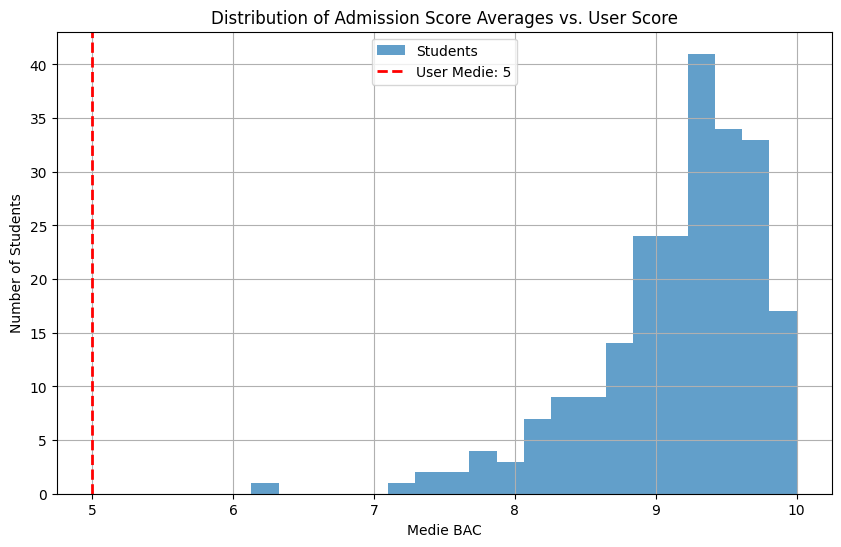

Average Score in this field: 9.15
Your BAC score is below the average.


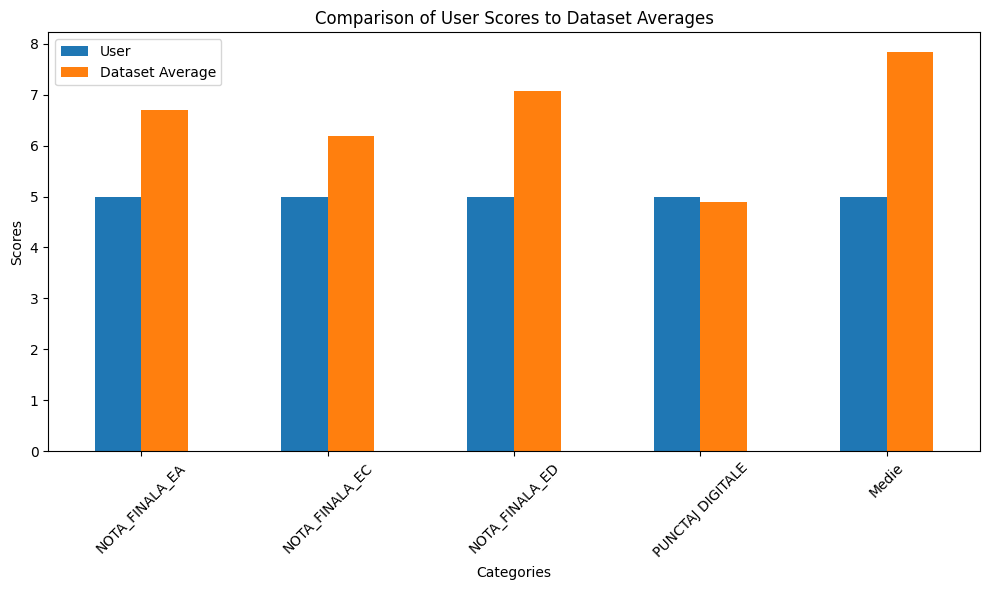

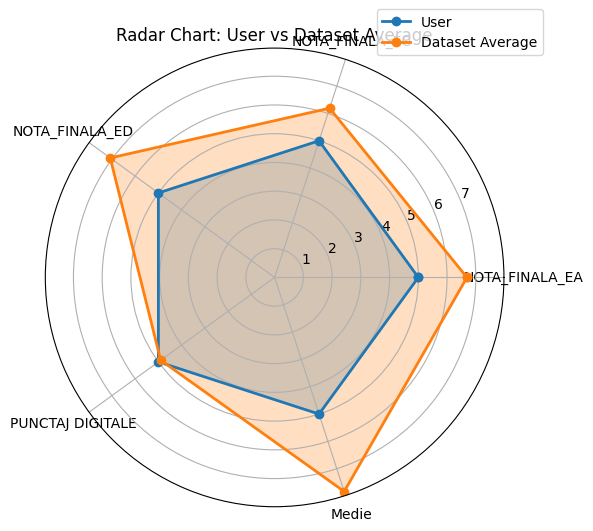

In [31]:
city = "Bucharest"
full_recommendation(city, user1)